In [1]:
#import geopandas as gpd
import pygeos
import pandas as pd
import json
import numpy as np
import pyproj
import itertools
from shapely.geometry import shape, MultiPoint, Polygon, LineString
#from shapely.prepared import prep
from shapely.ops import split
import polars as pl
import matplotlib.pyplot as plt
import src.config as config
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from dev.simu_gebco01 import zprofile
from src.polyhandler import polyhandler, process_polygon
from src.xmeridian import whichSide, crossBoundary

print(config.ds)
global ds
ds = config.ds

geojson_dict = {
    "type": "Polygon",
    "coordinates": [
        [
            [-3, 0.5],
            [-0.5, 1.5],
            [0.5, 3],
            [3, 3],
            [1, 1.5],
            [1, -0.5],
            [-3, 0.5]
        ]
    ]
}
geojson_string = json.dumps(geojson_dict)
geojson_str2 = '{"type": "Polygon", "coordinates": [[[0, 0], [0, 10], [10, 10], [10, 0], [0, 0]]]}'


# Read GeoJSON from dictionary
poly1 = pygeos.from_shapely(shape(geojson_dict))
#poly1 = pygeos.from_geojson(geojson_string)
poly2 = pygeos.from_geojson(geojson_str2)

# Do something with polygon, e.g. calculate area
print(pygeos.area(poly1) == pygeos.area(poly2))
print(poly1)
print(pygeos.envelope(poly1))
print(pygeos.bounds(poly1))
print(pygeos.boundary(poly1))
#print(pygeos.crs(poly1))

Data dir:  /home/bioer/python/gebco/data/GEBCO_2023_sub_ice_topo.zarr
Startup loading GEBCO-2023 zarr time:  0.40070199966430664 sec
Subsetting GEBCO-2023 zarr time:  0.006428956985473633 sec
shape: (38, 4)
┌────────────┬───────────┬───────┬──────────┐
│ longitude  ┆ latitude  ┆ z     ┆ distance │
│ ---        ┆ ---       ┆ ---   ┆ ---      │
│ f64        ┆ f64       ┆ i16   ┆ f64      │
╞════════════╪═══════════╪═══════╪══════════╡
│ 123.0      ┆ 22.13     ┆ -3620 ┆ 0.0      │
│ 123.003125 ┆ 22.127292 ┆ -3724 ┆ 0.440321 │
│ 123.007292 ┆ 22.123681 ┆ -3826 ┆ 0.587102 │
│ 123.011458 ┆ 22.120069 ┆ -3902 ┆ 0.58711  │
│ 123.015625 ┆ 22.116458 ┆ -3893 ┆ 0.587118 │
│ …          ┆ …         ┆ …     ┆ …        │
│ 123.136458 ┆ 22.011736 ┆ -5608 ┆ 0.587346 │
│ 123.140625 ┆ 22.008125 ┆ -5612 ┆ 0.587354 │
│ 123.144792 ┆ 22.004514 ┆ -5619 ┆ 0.587362 │
│ 123.148958 ┆ 22.000903 ┆ -5621 ┆ 0.58737  │
│ 123.15     ┆ 22.0      ┆ -5624 ┆ 0.146844 │
└────────────┴───────────┴───────┴──────────┘
<xarray.Dat

/home/bioer/.pyenv/versions/3.11.3/envs/py311/lib/python3.11/site-packages/pygeos/io.py:89: UserWarning: The shapely GEOS version (3.11.2-CAPI-1.17.2) is incompatible with the PyGEOS GEOS version (3.10.4-CAPI-1.16.2). Conversions between both will be slow
  warnings.warn(


In [ ]:
# Get bounding box of polygon and transform to geographic coordinates
minx, miny, maxx, maxy = pygeos.bounds(poly1)
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:4326")
minx, miny = transformer.transform(minx, miny)
maxx, maxy = transformer.transform(maxx, maxy)

# Create grid of points within bounding box
n_points = 100
x = np.linspace(minx, maxx, n_points)
y = np.linspace(miny, maxy, n_points)
xx, yy = np.meshgrid(x, y)
points = np.column_stack([xx.ravel(), yy.ravel()])
mpts = MultiPoint(points)
print(mpts)
gpts = pygeos.points(points)
print(gpts)

MULTIPOINT (-3 -0.5, -2.9393939393939394 -0.5, -2.878787878787879 -0.5, -2.8181818181818183 -0.5, -2.757575757575758 -0.5, -2.696969696969697 -0.5, -2.6363636363636362 -0.5, -2.5757575757575757 -0.5, -2.515151515151515 -0.5, -2.4545454545454546 -0.5, -2.393939393939394 -0.5, -2.333333333333333 -0.5, -2.2727272727272725 -0.5, -2.212121212121212 -0.5, -2.1515151515151514 -0.5, -2.090909090909091 -0.5, -2.0303030303030303 -0.5, -1.9696969696969697 -0.5, -1.9090909090909092 -0.5, -1.8484848484848484 -0.5, -1.7878787878787878 -0.5, -1.7272727272727273 -0.5, -1.6666666666666665 -0.5, -1.606060606060606 -0.5, -1.5454545454545454 -0.5, -1.4848484848484849 -0.5, -1.4242424242424243 -0.5, -1.3636363636363635 -0.5, -1.303030303030303 -0.5, -1.2424242424242424 -0.5, -1.1818181818181817 -0.5, -1.121212121212121 -0.5, -1.0606060606060606 -0.5, -1 -0.5, -0.9393939393939394 -0.5, -0.8787878787878789 -0.5, -0.8181818181818183 -0.5, -0.7575757575757573 -0.5, -0.6969696969696968 -0.5, -0.6363636363636362

In [ ]:
# Filter points within polygon using PyGEOS
polyx = shape(json.loads(geojson_string))
poly = pygeos.from_shapely(polyx)
mask = pygeos.within(gpts, poly)
result = points[mask]

# Transform points back to original coordinate system
#result = transformer.transform(result[:, 0], result[:, 1])

#result = []
#prep_polyx = prep(polyx)
#result.extend(filter(prep_polyx.contains, points))

# Convert points to DataFrame with longitude and latitude columns
df = pl.DataFrame({'longitude': result[:, 0],
                   'latitude': result[:, 1]})
print(df)

shape: (3_563, 2)
┌───────────┬───────────┐
│ longitude ┆ latitude  │
│ ---       ┆ ---       │
│ f64       ┆ f64       │
╞═══════════╪═══════════╡
│ 0.878788  ┆ -0.464646 │
│ 0.939394  ┆ -0.464646 │
│ 0.757576  ┆ -0.429293 │
│ 0.818182  ┆ -0.429293 │
│ …         ┆ …         │
│ 2.757576  ┆ 2.964646  │
│ 2.818182  ┆ 2.964646  │
│ 2.878788  ┆ 2.964646  │
│ 2.939394  ┆ 2.964646  │
└───────────┴───────────┘


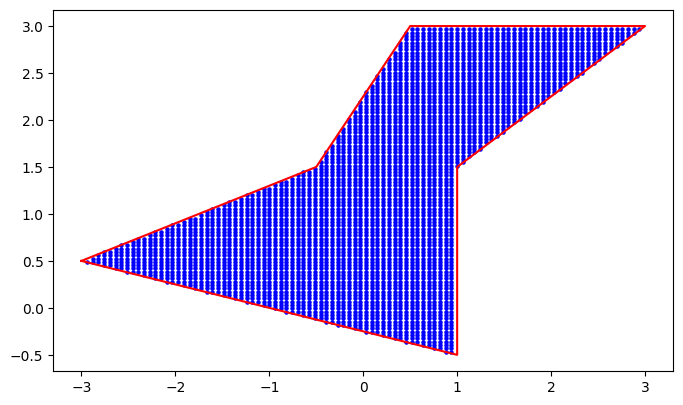

In [ ]:
# Plot original envelope of the polygon and points inside the envelope
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.plot(*polyx.exterior.xy, color="red")
ax.scatter(df["longitude"], df["latitude"], color="blue", s=5)
plt.show()

In [ ]:
geojson_string = json.dumps(geojson_dict)
poly1 = pygeos.from_shapely(shape(geojson_dict))

# Get bounding box of polygon and transform to geographic coordinates
minx, miny, maxx, maxy = pygeos.bounds(poly1)
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:4326")
minx, miny = transformer.transform(minx, miny)
maxx, maxy = transformer.transform(maxx, maxy)

# Create grid of points within bounding box
nx_points = 100
ny_points = 5
x = np.linspace(minx, maxx, nx_points)
y = np.linspace(miny, maxy, ny_points)
xx, yy = np.meshgrid(x, y)
points = np.column_stack([xx.ravel(), yy.ravel()])
mpts = MultiPoint(points)
print(mpts)
gpts = pygeos.points(points)

polyx = shape(json.loads(geojson_string))
poly = pygeos.from_shapely(polyx)
mask = pygeos.within(gpts, poly)
result = points[mask]

# Convert points to DataFrame with longitude and latitude columns
df1 = pl.DataFrame({'longitude': result[:, 0],
                    'latitude': result[:, 1]})
print(df1)

# Plot original envelope of the polygon and points inside the envelope
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.plot(*polyx.exterior.xy, color="red")
ax.scatter(df1["longitude"], df1["latitude"], color="blue", s=5)
plt.show()

In [ ]:
ply_hole_dict = {
    "type": "Polygon",
    "coordinates": [
        [
            [-3, 0.5],
            [-0.5, 1.5],
            [0.5, 3],
            [3, 3],
            [1, 1.5],
            [1, -0.5],
            [-3, 0.5]
        ],
        [
            [-1, 1],
            [1, 1],
            [0, 2],
            [-1, 1]
        ]
    ]
}
polyy = shape(ply_hole_dict)
poly2 = pygeos.from_shapely(polyy)
print(poly2)
#holes = [pygeos.from_shapely(shape(hole)) for hole in ply_hole_dict['coordinates'][1:]]
#hole = pygeos.unary_union(holes)

# Get bounding box of polygon and transform to geographic coordinates
minx, miny, maxx, maxy = pygeos.bounds(poly2)
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:4326")
minx, miny = transformer.transform(minx, miny)
maxx, maxy = transformer.transform(maxx, maxy)

# Create grid of points within bounding box
n_points = 100
x = np.linspace(minx, maxx, n_points)
y = np.linspace(miny, maxy, n_points)
xx, yy = np.meshgrid(x, y)
point2 = np.column_stack([xx.ravel(), yy.ravel()])

gpt2 = pygeos.points(point2)

# Check if points are within the polygon and not within any holes
mask1 = pygeos.within(gpts, poly2)
#mask2 = pygeos.intersects(gpt2, hole)
#mask = mask1 & ~mask2
result2 = point2[mask1]
df2 = pd.DataFrame({'longitude': result2[:, 0],
                    'latitude': result2[:, 1]})

In [ ]:
# import matplotlib.pyplot as plt
# Plot original envelope of the polygon and points inside the envelope
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.plot(*polyy.exterior.xy, color="red")
ax.scatter(df2["longitude"], df2["latitude"], color="blue", s=5)
plt.show()

In [ ]:
#import xarray as xr
#import importlib
#importlib.reload(simu_gebco01)
#import os
#os.chdir('/home/bioer/python/gebco')
#ds1 = xr.open_zarr(
#        'GEBCO_2022_sub_ice_topo.zarr', chunks='auto', group='gebco',
#        decode_cf=False, decode_times=False)
# test zprofile
print(zprofile(lon='123,123.15', lat='22.13,22', mode='dataframe'))
print(zprofile(lon='123,123.15', lat='22.13,22', mode='point,dataframe,zonly'))
print(zprofile(lon='123,123.15', lat='22.13', mode='dataframe'))

Subsetting GEBCO-2023 zarr time:  0.0013165473937988281 sec
shape: (38, 4)
┌────────────┬───────────┬───────┬──────────┐
│ longitude  ┆ latitude  ┆ z     ┆ distance │
│ ---        ┆ ---       ┆ ---   ┆ ---      │
│ f64        ┆ f64       ┆ i16   ┆ f64      │
╞════════════╪═══════════╪═══════╪══════════╡
│ 123.0      ┆ 22.13     ┆ -3620 ┆ 0.0      │
│ 123.003125 ┆ 22.127292 ┆ -3724 ┆ 0.440321 │
│ 123.007292 ┆ 22.123681 ┆ -3826 ┆ 0.587102 │
│ 123.011458 ┆ 22.120069 ┆ -3902 ┆ 0.58711  │
│ …          ┆ …         ┆ …     ┆ …        │
│ 123.140625 ┆ 22.008125 ┆ -5612 ┆ 0.587354 │
│ 123.144792 ┆ 22.004514 ┆ -5619 ┆ 0.587362 │
│ 123.148958 ┆ 22.000903 ┆ -5621 ┆ 0.58737  │
│ 123.15     ┆ 22.0      ┆ -5624 ┆ 0.146844 │
└────────────┴───────────┴───────┴──────────┘
Subsetting GEBCO-2023 zarr time:  0.0009377002716064453 sec
shape: (2, 3)
┌───────────┬──────────┬───────┐
│ longitude ┆ latitude ┆ z     │
│ ---       ┆ ---      ┆ ---   │
│ f64       ┆ f64      ┆ i16   │
╞═══════════╪══════════╪═════

In [ ]:
## test line ##
line_dict1 = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            -13.413081630775764,
            -6.920092253225349
          ],
          [
            -7.630064084242605,
            -3.7209743988855024
          ],
          [
            -5.1333868275576435,
            -5.224021020321388
          ]
        ],
        "type": "LineString"
      }
    }
  ]
}

ply1 = pygeos.from_geojson(json.dumps(line_dict1))
print(ply1)
coordx = pygeos.get_coordinates(ply1)
locx = coordx[:,0]
locy = coordx[:,1]
print(locx, locy)
out = zprofile(lon=','.join(str(x) for x in locx),
               lat=','.join(str(y) for y in locy), mode='dataframe')
print(out)


GEOMETRYCOLLECTION (LINESTRING (-13.413 -6.92, -7.63 -3.721, -5.133 -5.224))
[-13.41308163  -7.63006408  -5.13338683] [-6.92009225 -3.7209744  -5.22402102]
Subsetting GEBCO-2023 zarr time:  0.0008180141448974609 sec
shape: (1_990, 4)
┌────────────┬───────────┬───────┬──────────┐
│ longitude  ┆ latitude  ┆ z     ┆ distance │
│ ---        ┆ ---       ┆ ---   ┆ ---      │
│ f64        ┆ f64       ┆ i16   ┆ f64      │
╞════════════╪═══════════╪═══════╪══════════╡
│ -13.413082 ┆ -6.920092 ┆ -3228 ┆ 0.0      │
│ -13.409375 ┆ -6.918042 ┆ -3237 ┆ 0.468212 │
│ -13.405208 ┆ -6.915737 ┆ -3251 ┆ 0.526324 │
│ -13.401042 ┆ -6.913432 ┆ -3261 ┆ 0.526326 │
│ …          ┆ …         ┆ …     ┆ …        │
│ -5.142708  ┆ -5.218409 ┆ -4421 ┆ 0.538811 │
│ -5.138542  ┆ -5.220918 ┆ -4403 ┆ 0.538809 │
│ -5.134375  ┆ -5.223426 ┆ -4440 ┆ 0.538808 │
│ -5.133387  ┆ -5.224021 ┆ -4440 ┆ 0.127784 │
└────────────┴───────────┴───────┴──────────┘


In [ ]:
multiline_dict1 =  {
   "type": "MultiLineString",
   "coordinates": [
     [
       [100.0, 0.0],
       [101.0, 1.0]
     ],
     [
       [102.0, 2.0],
       [103.0, 3.0]
     ]
   ]
 }
ply2 = pygeos.from_geojson(json.dumps(multiline_dict1))
print(ply2)
coordx = pygeos.get_coordinates(ply2)
locx = coordx[:,0]
locy = coordx[:,1]
print(locx, locy)

out_mline = zprofile(lon=','.join(str(x) for x in locx),
                     lat=','.join(str(y) for y in locy), mode='dataframe')
print(out_mline) #Should consider if endpoint between L1, L2 should output zprofile points? I think should not

MULTILINESTRING ((100 0, 101 1), (102 2, 103 3))
[100. 101. 102. 103.] [0. 1. 2. 3.]
Subsetting GEBCO-2023 zarr time:  0.000911712646484375 sec
shape: (724, 4)
┌────────────┬──────────┬─────┬──────────┐
│ longitude  ┆ latitude ┆ z   ┆ distance │
│ ---        ┆ ---      ┆ --- ┆ ---      │
│ f64        ┆ f64      ┆ i16 ┆ f64      │
╞════════════╪══════════╪═════╪══════════╡
│ 100.0      ┆ 0.0      ┆ 343 ┆ 0.0      │
│ 100.003125 ┆ 0.003125 ┆ 402 ┆ 0.490323 │
│ 100.007292 ┆ 0.007292 ┆ 399 ┆ 0.653764 │
│ 100.011458 ┆ 0.011458 ┆ 402 ┆ 0.653764 │
│ …          ┆ …        ┆ …   ┆ …        │
│ 102.990625 ┆ 2.990625 ┆ 62  ┆ 0.653329 │
│ 102.994792 ┆ 2.994792 ┆ 52  ┆ 0.653328 │
│ 102.998958 ┆ 2.998958 ┆ 58  ┆ 0.653326 │
│ 103.0      ┆ 3.0      ┆ 58  ┆ 0.163331 │
└────────────┴──────────┴─────┴──────────┘


In [ ]:
# Example GeoJSON string with LineString and MultiLineString
geojson_str = '''
{
        "type": "GeometryCollection",
        "geometries": [
            {
                "type": "MultiLineString",
                "coordinates": [
                    [[104, 4], [105, 5], [106, 6]],
                    [[107, 7], [108, 8], [109, 9]]
                ]
            },        
            {
                "type": "LineString",
                "coordinates": [
                    [100, 0], [101, 1], [102, 2], [103, 3]
                ]
            }
        ]
}
'''
#pygeos.get_type_id
#None (missing) is -1
#POINT is 0
#LINESTRING is 1
#LINEARRING is 2
#POLYGON is 3
#MULTIPOINT is 4
#MULTILINESTRING is 5
#MULTIPOLYGON is 6
#GEOMETRYCOLLECTION is 7

# Parse GeoJSON into a dictionary
geojson_dict = json.loads(geojson_str)

# Create empty lists for collecting the output
df_rows = []
line_id = 0

# Iterate over all geometries in the GeometryCollection
for geom in geojson_dict['geometries']:
    # Extract the coordinates from the geometry
    coords = geom['coordinates']
    # Convert the coordinates to a PyGEOS geometry object
    geox = pygeos.linestrings(coords) if geom['type'] == 'LineString' else pygeos.multilinestrings(coords)
    print(geox)
    #print(pygeos.get_coordinates(geox))
    typex = pygeos.get_type_id(geox)
    print(typex)

    if typex == 5:  # MultiLineString
        lines = pygeos.get_parts(geox)
        print(lines)
        #lines = lines.tolist()
        #print(lines)
        for i, line in enumerate(lines):
            df_rows.extend([(pt[0], pt[1], i) for pt in pygeos.get_coordinates(line)])
            line_id = line_id + 1
    elif typex == 1:  # LineString:
        df_rows.extend([(pt[0], pt[1], line_id) for pt in pygeos.get_coordinates(geox)])

# Create the DataFrame
df = pl.DataFrame(df_rows, schema={'longitude':pl.Float64, 'latitude':pl.Float64, 'lineid': pl.Int16})
print(df)


MULTILINESTRING ((104 4, 105 5, 106 6), (107 7, 108 8, 109 9))
5
[<pygeos.Geometry LINESTRING (104 4, 105 5, 106 6)>
 <pygeos.Geometry LINESTRING (107 7, 108 8, 109 9)>]
LINESTRING (100 0, 101 1, 102 2, 103 3)
1
shape: (10, 3)
┌───────────┬──────────┬────────┐
│ longitude ┆ latitude ┆ lineid │
│ ---       ┆ ---      ┆ ---    │
│ f64       ┆ f64      ┆ i16    │
╞═══════════╪══════════╪════════╡
│ 104.0     ┆ 4.0      ┆ 0      │
│ 105.0     ┆ 5.0      ┆ 0      │
│ 106.0     ┆ 6.0      ┆ 0      │
│ 107.0     ┆ 7.0      ┆ 1      │
│ …         ┆ …        ┆ …      │
│ 100.0     ┆ 0.0      ┆ 2      │
│ 101.0     ┆ 1.0      ┆ 2      │
│ 102.0     ┆ 2.0      ┆ 2      │
│ 103.0     ┆ 3.0      ┆ 2      │
└───────────┴──────────┴────────┘


In [ ]:
# Plot the lines with different colors according to line ID
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 10))

for line_id in df['lineid'].unique():
    line = df.filter(pl.col('lineid') == line_id)
    ax.plot(line['longitude'], line['latitude'], label=f'Line {line_id}')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.show()

In [ ]:
final_df_rows = []
line_id = 0
for geom in geojson_dict['geometries']:
    coords = geom['coordinates']
    geox = pygeos.linestrings(coords) if geom['type'] == 'LineString' else pygeos.multilinestrings(coords)
    typex = pygeos.get_type_id(geox)

    if typex == 5:  # MultiLineString
        lines = pygeos.get_parts(geox)
        for line in lines:
            coordx = pygeos.get_coordinates(line)
            locx = coordx[:, 0]
            locy = coordx[:, 1]
            zout = zprofile(lon=','.join(str(x) for x in locx),
                            lat=','.join(str(y) for y in locy), mode='dataframe')
            #print(zout)
            for row in zout.rows():
                final_df_rows.append((row[0], row[1], row[2], row[3], line_id))
            line_id += 1
    elif typex == 1:  # LineString
        coordx = pygeos.get_coordinates(geox)
        locx = coordx[:, 0]
        locy = coordx[:, 1]
        zout = zprofile(lon=','.join(str(x) for x in locx),
                        lat=','.join(str(y) for y in locy), mode='dataframe')
        for row in zout.rows():
            final_df_rows.append((row[0], row[1], row[2], row[3], line_id))
        line_id += 1

# Create the final DataFrame
final_df = pl.DataFrame(final_df_rows, schema={'longitude': pl.Float64, 'latitude': pl.Float64, 'z': pl.Float64, 'distance': pl.Float64, 'lineid': pl.Int16})
print(final_df)

Subsetting GEBCO-2023 zarr time:  0.0011212825775146484 sec
Subsetting GEBCO-2023 zarr time:  0.0006513595581054688 sec
Subsetting GEBCO-2023 zarr time:  0.0006241798400878906 sec
shape: (1_690, 5)
┌────────────┬──────────┬───────┬──────────┬────────┐
│ longitude  ┆ latitude ┆ z     ┆ distance ┆ lineid │
│ ---        ┆ ---      ┆ ---   ┆ ---      ┆ ---    │
│ f64        ┆ f64      ┆ f64   ┆ f64      ┆ i16    │
╞════════════╪══════════╪═══════╪══════════╪════════╡
│ 104.0      ┆ 4.0      ┆ -52.0 ┆ 0.0      ┆ 0      │
│ 104.003125 ┆ 4.003125 ┆ -52.0 ┆ 0.489738 ┆ 0      │
│ 104.007292 ┆ 4.007292 ┆ -53.0 ┆ 0.652983 ┆ 0      │
│ 104.011458 ┆ 4.011458 ┆ -51.0 ┆ 0.652981 ┆ 0      │
│ …          ┆ …        ┆ …     ┆ …        ┆ …      │
│ 102.990625 ┆ 2.990625 ┆ 62.0  ┆ 0.653329 ┆ 2      │
│ 102.994792 ┆ 2.994792 ┆ 52.0  ┆ 0.653328 ┆ 2      │
│ 102.998958 ┆ 2.998958 ┆ 58.0  ┆ 0.653326 ┆ 2      │
│ 103.0      ┆ 3.0      ┆ 58.0  ┆ 0.163331 ┆ 2      │
└────────────┴──────────┴───────┴──────────┴──

In [5]:
#import matplotlib.pyplot as plt
def plot_z_profiles(data, legend=True, onlyz=False):
    plt.figure(figsize=(10, 5))

    # Check if 'distance' column is present
    has_distance = 'distance' in data.columns
    has_lineid = 'lineid' in data.columns

    # Group data by lineid and plot each group
    if onlyz:
       plt.plot(data['z']) 
    elif has_lineid:
        for line_id, group_data in data.groupby('lineid'):
            z = group_data['z']
            if has_distance:
                distances = group_data['distance']
                # Calculate cumulative distances for each group
                cumulative_distances = list(itertools.accumulate(distances))
                plt.plot(cumulative_distances, z, label=f'Line ID {line_id}')
            else:
                plt.plot(z, label=f'Line ID {line_id}')
    else:
        plt.plot(data['z'])            

    plt.xlabel("Distance (km)" if has_distance else "Index")
    plt.ylabel("Elevation (m)")
    plt.title("Z-profile")
    if legend:
        plt.legend()
    plt.show()

# Example usage
# plot_z_profiles(final_df)


/tmp/ipykernel_2521643/2304614259.py:9: DeprecationWarning: `groupby` is deprecated. It has been renamed to `group_by`.
  for line_id, group_data in data.groupby('lineid'):


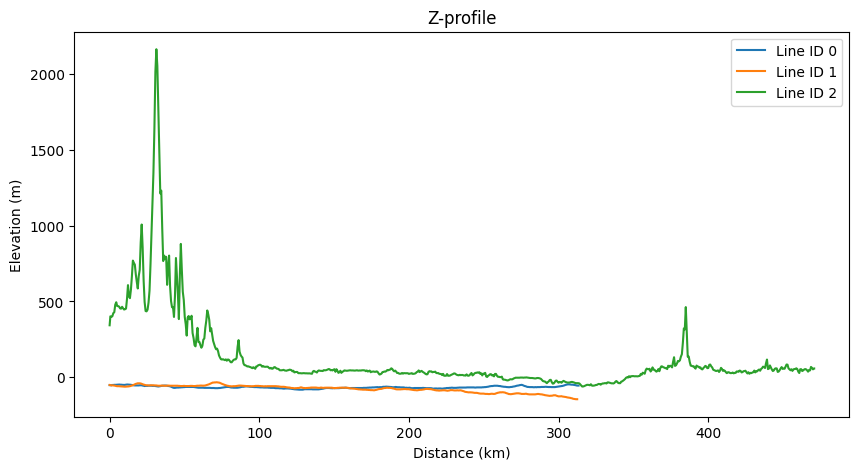

In [ ]:
plot_z_profiles(final_df)

In [2]:
pts_dict = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [-122.4194, 37.7749]
            },
            "properties": {
                "name": "Point 1"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [-122.4382, 37.7592]
            },
            "properties": {
                "name": "Point 2"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [-122.4183, 37.7754]
            },
            "properties": {
                "name": "Point 3"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": [-122.4233, 37.7764]
            },
            "properties": {
                "name": "Point 4"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "MultiPoint",
                "coordinates": [[-122.4194, 37.7749], [-122.4382, 37.7592], [-122.4183, 37.7754], [-122.4233, 37.7764], [-122.4076, 37.7848], [-122.4155, 37.7765], [-122.4115, 37.7858], [-122.4063, 37.7861], [-122.4057, 37.7792], [-122.4232, 37.7799]]
            },
            "properties": {
                "name": "MultiPoint 1"
            }
        },
        {
            "type": "Feature",
            "geometry": {
                "type": "MultiPoint",
                "coordinates": [[-122.4207, 37.7791], [-122.4322, 37.7769], [-122.4177, 37.7733], [-122.4099, 37.7772], [-122.4068, 37.7836], [-122.4197, 37.7838], [-122.4093, 37.7793], [-122.4157, 37.778], [-122.4102, 37.7789], [-122.4147, 37.7772]]
            },
            "properties": {
                "name": "MultiPoint 2"
            }
        }
    ]
}

#ptx = []
ptx = np.empty(shape=[0, 2], dtype=float)

#for geom in pts_dict['features']:
    # Extract the coordinates from the geometry
#    coords = geom['geometry']['coordinates']
    # Convert the coordinates to a PyGEOS geometry object
#    geox = pygeos.points(coords) if geom['geometry']['type'] == 'Point' else pygeos.multipoints(coords)
#    print(geox)
    #print(pygeos.get_coordinates(geox))
    #typex = pygeos.get_type_id(geox)
    #print(typex)
#    ptx.extend(tuple(crdx) for crdx in pygeos.get_coordinates(geox).tolist())
for feature in pts_dict['features']:
    geometry = feature['geometry']
    if geometry['type'] == 'Point':
        coords = np.array(pygeos.get_coordinates(pygeos.points(geometry['coordinates'])))
    elif geometry['type'] == 'MultiPoint':
        coords = np.array(pygeos.get_coordinates(pygeos.multipoints(geometry['coordinates'])))
    else:
        continue  # ignore other types of geometries
    
    ptx = np.vstack([ptx, coords])

#print(ptx)
dfpt = pl.DataFrame({'longitude':ptx[:,0], 'latitude':ptx[:,1]})
#print(dfpt)

locx = ptx[:, 0]
locy = ptx[:, 1]
#zout = zprofile(lon=','.join(str(x) for x in locx),
#                lat=','.join(str(y) for y in locy), mode='dataframe')
zout = zprofile(locx, locy, mode='dataframe')
print(zout)

Subsetting GEBCO-2023 zarr time:  0.002498626708984375 sec
shape: (68, 4)
┌─────────────┬───────────┬─────┬──────────┐
│ longitude   ┆ latitude  ┆ z   ┆ distance │
│ ---         ┆ ---       ┆ --- ┆ ---      │
│ f64         ┆ f64       ┆ i16 ┆ f64      │
╞═════════════╪═══════════╪═════╪══════════╡
│ -122.4194   ┆ 37.7749   ┆ 16  ┆ 0.0      │
│ -122.421875 ┆ 37.772833 ┆ 25  ┆ 0.316504 │
│ -122.426042 ┆ 37.769354 ┆ 33  ┆ 0.532844 │
│ -122.430208 ┆ 37.765874 ┆ 40  ┆ 0.532855 │
│ …           ┆ …         ┆ …   ┆ …        │
│ -122.4157   ┆ 37.778    ┆ 22  ┆ 0.196269 │
│ -122.4102   ┆ 37.7789   ┆ 11  ┆ 0.494718 │
│ -122.413542 ┆ 37.777638 ┆ 22  ┆ 0.326033 │
│ -122.4147   ┆ 37.7772   ┆ 22  ┆ 0.113015 │
└─────────────┴───────────┴─────┴──────────┘


In [10]:
mpt_json = '''{
                "type": "MultiPoint",
                "coordinates": [[-122.4194, 37.7749], [-122.4382, 37.7592], [-122.4183, 37.7754], [-122.4233, 37.7764], [-122.4076, 37.7848], [-122.4155, 37.7765], [-122.4115, 37.7858], [-122.4063, 37.7861], [-122.4057, 37.7792], [-122.4232, 37.7799]]
            }'''
geometry = pygeos.from_shapely(shape(json.loads(mpt_json)))
coordx = pygeos.get_coordinates(geometry)
locx = coordx[:, 0]
locy = coordx[:, 1]
print(geometry)
print(coordx)


MULTIPOINT (-122.419 37.775, -122.438 37.759, -122.418 37.775, -122.423 37.776, -122.408 37.785, -122.416 37.776, -122.412 37.786, -122.406 37.786, -122.406 37.779, -122.423 37.78)
[[-122.4194   37.7749]
 [-122.4382   37.7592]
 [-122.4183   37.7754]
 [-122.4233   37.7764]
 [-122.4076   37.7848]
 [-122.4155   37.7765]
 [-122.4115   37.7858]
 [-122.4063   37.7861]
 [-122.4057   37.7792]
 [-122.4232   37.7799]]


In [ ]:
# Instead of using np.vstack, which can be less efficient due to repeated memory allocation,
# consider using list comprehension and then converting the list to a NumPy array. 
# This approach can be more efficient in Python.
import numpy as np
import pygeos
import polars as pl

def process_points(pts_dict):
    coords_list = []

    for feature in pts_dict['features']:
        geometry = feature['geometry']
        if geometry['type'] == 'Point':
            coords_list.append(geometry['coordinates'])
        elif geometry['type'] == 'MultiPoint':
            coords_list.extend(geometry['coordinates'])

    # Convert list to NumPy array
    coords = np.array(coords_list)

    # Extract longitude and latitude
    locx, locy = coords[:, 0], coords[:, 1]

    # Call zprofile function
    zout = zprofile(lon=','.join(str(x) for x in locx),
                    lat=','.join(str(y) for y in locy), mode='dataframe')
    return zout

# Example usage
zout = process_points(pts_dict)
print(zout)


Subsetting GEBCO-2023 zarr time:  0.0013759136199951172 sec
shape: (68, 4)
┌─────────────┬───────────┬─────┬──────────┐
│ longitude   ┆ latitude  ┆ z   ┆ distance │
│ ---         ┆ ---       ┆ --- ┆ ---      │
│ f64         ┆ f64       ┆ i16 ┆ f64      │
╞═════════════╪═══════════╪═════╪══════════╡
│ -122.4194   ┆ 37.7749   ┆ 16  ┆ 0.0      │
│ -122.421875 ┆ 37.772833 ┆ 25  ┆ 0.316504 │
│ -122.426042 ┆ 37.769354 ┆ 33  ┆ 0.532844 │
│ -122.430208 ┆ 37.765874 ┆ 40  ┆ 0.532855 │
│ …           ┆ …         ┆ …   ┆ …        │
│ -122.4157   ┆ 37.778    ┆ 22  ┆ 0.196269 │
│ -122.4102   ┆ 37.7789   ┆ 11  ┆ 0.494718 │
│ -122.413542 ┆ 37.777638 ┆ 22  ┆ 0.326033 │
│ -122.4147   ┆ 37.7772   ┆ 22  ┆ 0.113015 │
└─────────────┴───────────┴─────┴──────────┘


In [4]:
## use polyhandler
ptout, _ = polyhandler(pts_dict, 0, mode='zonly,connect_pt') #, or 'connect_pts' 
print(ptout)

Got geometry:  MULTIPOINT (-122.419 37.775, -122.438 37.759, -122.418 37.775, -122.423 37.776, -122.408 37.785, -122.416 37.776, -122.412 37.786, -122.406 37.786, -122.406 37.779, -122.423 37.78)  with type id:  4  with mode:  zonly,connect_pt,dataframe
Got geometry:  MULTIPOINT (-122.421 37.779, -122.432 37.777, -122.418 37.773, -122.41 37.777, -122.407 37.784, -122.42 37.784, -122.409 37.779, -122.416 37.778, -122.41 37.779, -122.415 37.777)  with type id:  4  with mode:  zonly,connect_pt,dataframe
shape: (68, 4)
┌─────────────┬───────────┬──────┬────────┐
│ longitude   ┆ latitude  ┆ z    ┆ lineid │
│ ---         ┆ ---       ┆ ---  ┆ ---    │
│ f64         ┆ f64       ┆ f64  ┆ i16    │
╞═════════════╪═══════════╪══════╪════════╡
│ -122.4194   ┆ 37.7749   ┆ 16.0 ┆ 0      │
│ -122.421875 ┆ 37.772833 ┆ 25.0 ┆ 0      │
│ -122.426042 ┆ 37.769354 ┆ 33.0 ┆ 0      │
│ -122.430208 ┆ 37.765874 ┆ 40.0 ┆ 0      │
│ …           ┆ …         ┆ …    ┆ …      │
│ -122.4157   ┆ 37.778    ┆ 22.0 ┆ 2   

In [2]:
# Your existing code to define the polygon...
geojson_dict = {
    "type": "Polygon",
    "coordinates": [
        [
            [-3, 0.5],
            [-0.5, 1.5],
            [0.5, 3],
            [3, 3],
            [1, 1.5],
            [1.5, -0.5],
            [-3, 0.5]
        ]
    ]
}
geojson_string = json.dumps(geojson_dict)
polyx = shape(json.loads(geojson_string))
poly = pygeos.from_shapely(polyx)

# Define the interval for line strings (15 arc-seconds in degrees)
arc_seconds = 15
interval = arc_seconds / 3600  # Convert arc-seconds to degrees

# Get bounding box of the polygon
minx, miny, maxx, maxy = pygeos.bounds(poly)

print(minx, miny, maxx, maxy)

-3.0 -0.5 3.0 3.0


In [5]:
# {"type": "Polygon", "coordinates": [[[-0.5, 0.5], [-0.5, 1.5], [0.5, 1.8], [1.8, 1.8], [1, 1.5], [1.5, -0.5], [-0.5, 0.5]]]}
print(geojson_string)
bbox = (minx, miny, maxx, maxy)
x1, y1, x2, y2 = bbox
print(x1, y1, x2,  y2)

{"type": "Polygon", "coordinates": [[[-3, 0.5], [-0.5, 1.5], [0.5, 3], [3, 3], [1, 1.5], [1.5, -0.5], [-3, 0.5]]]}
-3.0 -0.5 3.0 3.0


In [ ]:
'''
# Move to src/polyhandler.py
def create_vertical_linestrings(minx, maxx, interval):
    x_coords = np.arange(minx, maxx, interval)
    return [((x, miny), (x, maxy)) for x in x_coords]

# SLOW because too much zprofile() call
def process_polygon(polygon, line_id, interval):
    minx, miny, maxx, maxy = pygeos.bounds(polygon)
    vertical_lines = create_vertical_linestrings(minx, maxx, interval)
    consistent_schema = {'longitude': pl.Float64, 'latitude': pl.Float64, 'z': pl.Float64, 'distance': pl.Float64, 'lineid': pl.Int16}
    dataframes = []

    for line_coords in vertical_lines:
        line = pygeos.linestrings([line_coords])
        if not pygeos.intersects(polygon, line):
            continue

        intersection = pygeos.intersection(polygon, line)
        coords = pygeos.get_coordinates(intersection)
        zout = zprofile(lon=','.join(str(coord[0]) for coord in coords),
                        lat=','.join(str(coord[1]) for coord in coords), mode='dataframe')

        # Filter out points outside the polygon
        points = pygeos.points(zout['longitude'], zout['latitude'])
        mask = pygeos.within(points, polygon)
        filtered_zout = zout.filter(mask)

        filtered_zout = filtered_zout.with_columns([pl.lit(line_id).cast(pl.Int16).alias('lineid')])
        dataframes.append(filtered_zout) #.cast(consistent_schema)
        line_id += 1

    if dataframes:
        dataframes = [df.cast(consistent_schema) for df in dataframes]
        return pl.concat(dataframes)
    else:
        return pl.DataFrame([], schema=consistent_schema)    
'''

In [3]:
df2 = process_polygon(poly, 0, "dataframe")

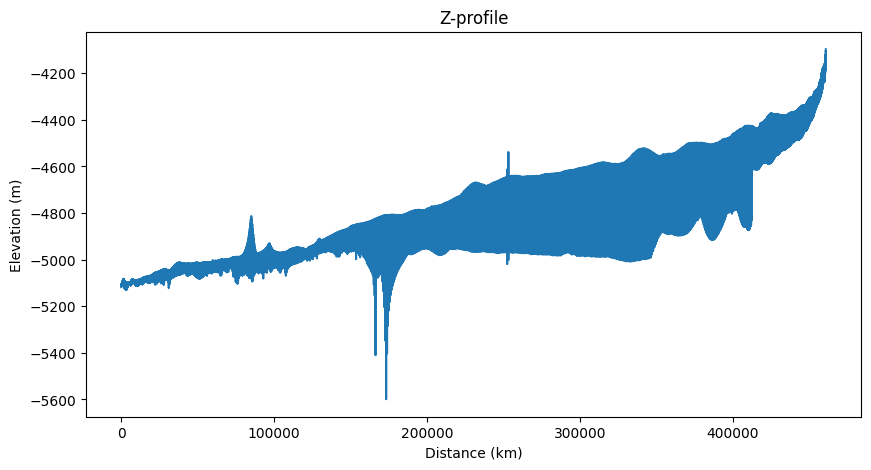

In [6]:
plot_z_profiles(df2, legend=False, onlyz=True)

In [7]:
def plot_polygon_and_points(polygon, points_df, legend=False, onlyz=False):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect("equal")

    # Plot the polygon
    poly_exterior = pygeos.get_exterior_ring(polygon)
    exterior_coords = pygeos.get_coordinates(poly_exterior)
    ax.plot(exterior_coords[:, 0], exterior_coords[:, 1], color="red")

    # Plot the points
    # If you want to use different colors for different line IDs, you can loop through them
    if onlyz:
       ax.scatter(points_df['longitude'], points_df['latitude'], s=5) 
    elif 'lineid' in points_df.columns:
        for line_id in points_df['lineid'].unique():
            line_points = points_df.filter(pl.col('lineid') == line_id)
            ax.scatter(line_points['longitude'], line_points['latitude'], s=5, label=f'Line ID {line_id}')
    else:
        ax.scatter(points_df['longitude'], points_df['latitude'], s=5)

    if legend:
        plt.legend()
    plt.show()

# Example usage


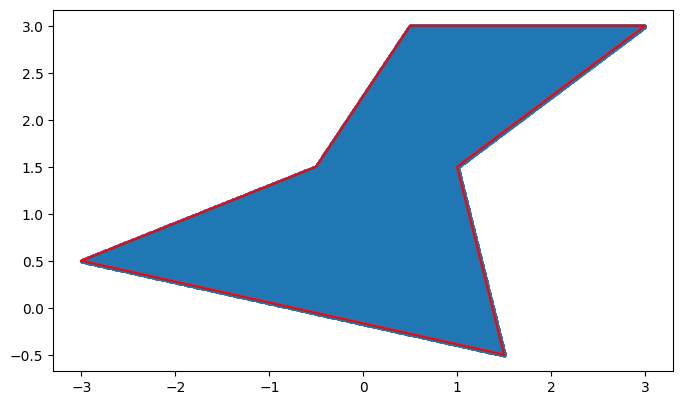

In [8]:
plot_polygon_and_points(poly, df2, False, True)

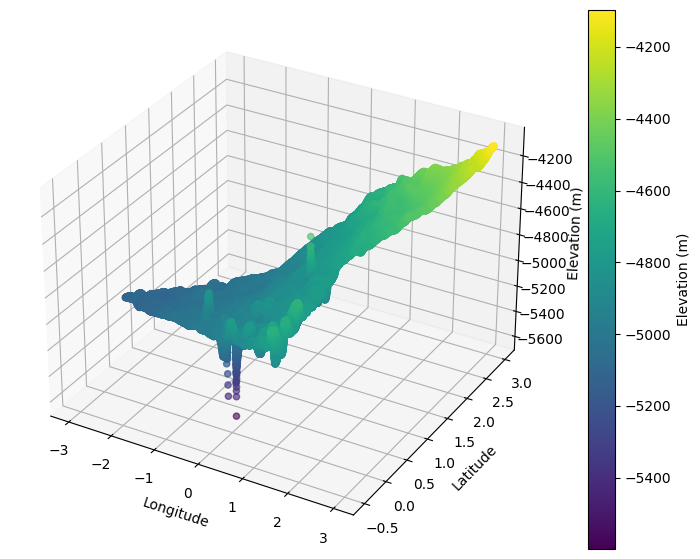

In [9]:
#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D

def plot_3d_z_profile(df):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot using longitude, latitude, and z
    sc = ax.scatter(df['longitude'], df['latitude'], df['z'], c=df['z'], cmap='viridis')

    # Adding labels
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Elevation (m)')

    # Color bar indicating elevation
    plt.colorbar(sc, ax=ax, label='Elevation (m)')

    plt.show()

# Example usage
plot_3d_z_profile(df2)


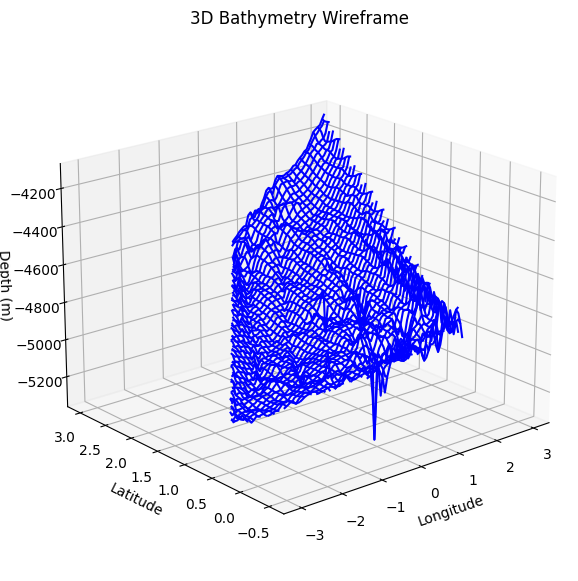

In [10]:
#import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
#import numpy as np
#from scipy.interpolate import griddata

def plot_3d_bathymetry_wireframe(df):
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Extract longitude, latitude, and z values
    lons = df['longitude'].to_numpy()
    lats = df['latitude'].to_numpy()
    z_values = df['z'].to_numpy()

    # Create a grid
    unique_lons = np.linspace(lons.min(), lons.max(), num=100)  # Adjust num for resolution
    unique_lats = np.linspace(lats.min(), lats.max(), num=100)  # Adjust num for resolution
    X, Y = np.meshgrid(unique_lons, unique_lats)

    # Interpolate Z values for the grid
    Z = griddata((lons, lats), z_values, (X, Y), method='linear')

    # Plot wireframe
    ax.plot_wireframe(X, Y, Z, color='blue')

    # Set labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('Depth (m)')
    ax.set_title('3D Bathymetry Wireframe')

    # Set the view for better visualization of bathymetry
    ax.view_init(azim=230, elev=20)

    plt.show()

# Example usage
plot_3d_bathymetry_wireframe(df2)


In [ ]:
'''
# Move to src/polyhandler.py #

def process_linestring(line, line_id):
    coordx = pygeos.get_coordinates(line)
    locx = coordx[:, 0]
    locy = coordx[:, 1]
    zout = zprofile(lon=','.join(str(x) for x in locx),
                    lat=','.join(str(y) for y in locy), mode='dataframe')
    # Add line_id column to the DataFrame
    zout = zout.with_columns(pl.lit(line_id).alias('lineid'))
    return zout

def process_polygon(polygon, line_id, interval):
    minx, miny, maxx, maxy = pygeos.bounds(polygon)
    vertical_lines = create_vertical_linestrings(minx, maxx, interval)
    dataframes = []

    for line_coords in vertical_lines:
        line = pygeos.linestrings([line_coords])
        if not pygeos.intersects(polygon, line):
            continue

        intersection = pygeos.intersection(polygon, line)
        coords = pygeos.get_coordinates(intersection)
        zout = zprofile(lon=','.join(str(coord[0]) for coord in coords),
                        lat=','.join(str(coord[1]) for coord in coords), mode='dataframe')
        zout = zout.with_columns(pl.lit(line_id).alias('lineid'))
        dataframes.append(zout)
        line_id += 1

    if dataframes:
        return pl.concat(dataframes)
    else:
        return pl.DataFrame([], schema={'longitude': pl.Float64, 'latitude': pl.Float64, 'z': pl.Float64, 'distance': pl.Float64, 'lineid': pl.Int16})


def universal_handler(geojson_input, line_id=0):
    if isinstance(geojson_input, str):
        geometry = pygeos.from_shapely(shape(json.loads(geojson_input)))
    elif isinstance(geojson_input, pygeos.lib.Geometry):
        geometry = geojson_input
    else:
        raise ValueError("Input must be a GeoJSON string or a PyGEOS Geometry")

    print("Got geometry: ", geometry)
    geom_type = pygeos.get_type_id(geometry)
    dataframes = []
    interval = 15 / 3600  # 15 arc-seconds in degrees

    if geom_type in [0, 1, 2]:  # POINT, LINESTRING, LINEARRING
        df = process_linestring(geometry, line_id)
        dataframes.append(df)
    elif geom_type == 3:  # POLYGON
        df = process_polygon(geometry, line_id, interval)
        dataframes.append(df)
    elif geom_type in [4, 5]:  # MULTIPOINT, MULTILINESTRING
        for part in pygeos.get_parts(geometry):
            df = process_linestring(part, line_id)
            dataframes.append(df)
            line_id += 1
    elif geom_type == 6:  # MULTIPOLYGON
        for polygon in pygeos.get_parts(geometry):
            df = process_polygon(polygon, line_id, interval)
            dataframes.append(df)
            line_id += 1
    elif geom_type == 7:  # GEOMETRYCOLLECTION
        for part in pygeos.get_parts(geometry):
            part_df, line_id = universal_handler(part, line_id)
            dataframes.append(part_df)

    if not dataframes:
        return pl.DataFrame([], schema={'longitude': pl.Float64, 'latitude': pl.Float64, 'z': pl.Float64, 'distance': pl.Float64, 'lineid': pl.Int16}), line_id

    final_df = pl.concat(dataframes)
    return final_df, line_id
# Example usage with a GeoJSON input
# zout = universal_handler(your_geojson_input)
'''

In [3]:
gfstr = '''
{
        "type": "GeometryCollection",
        "geometries": [
            {
                "type": "MultiLineString",
                "coordinates": [
                    [[104, 4], [105, 5], [106, 6]],
                    [[107, 7], [108, 8], [109, 9]]
                ]
            },        
            {
                "type": "LineString",
                "coordinates": [
                    [100, 0], [101, 1], [102, 2], [103, 3]
                ]
            },
            {
                "type": "Polygon",
                "coordinates": [
                  [
                    [97, 0.5],
                    [99.5, 1.5],
                    [100.5, 3],
                    [103, 3],
                    [101, 1.5],
                    [101.5, -0.5],
                    [97, 0.5]
                  ]
                ]
            }
        ]
}
'''
#gf1 = json.loads(gf1) #json.dumps(
print(gfstr.replace(" ", "").replace('\n', '').replace('\r', ''))


{"type":"GeometryCollection","geometries":[{"type":"MultiLineString","coordinates":[[[104,4],[105,5],[106,6]],[[107,7],[108,8],[109,9]]]},{"type":"LineString","coordinates":[[100,0],[101,1],[102,2],[103,3]]},{"type":"Polygon","coordinates":[[[97,0.5],[99.5,1.5],[100.5,3],[103,3],[101,1.5],[101.5,-0.5],[97,0.5]]]}]}


In [4]:
gfout, _ = polyhandler(gfstr, 0, "zonly")
print(gfout)


Got geometry:  GEOMETRYCOLLECTION (MULTILINESTRING ((104 4, 105 5, 106 6), (107 7, 108 8, 109 9)), LINESTRING (100 0, 101 1, 102 2, 103 3), POLYGON ((97 0.5, 99.5 1.5, 100.5 3, 103 3, 101 1.5, 101.5 -0.5, 97 0.5)))  with type id:  7  with mode:  zonly,dataframe
Got geometry:  MULTILINESTRING ((104 4, 105 5, 106 6), (107 7, 108 8, 109 9))  with type id:  5  with mode:  zonly,dataframe
Got geometry:  LINESTRING (100 0, 101 1, 102 2, 103 3)  with type id:  1  with mode:  zonly,dataframe
Got geometry:  POLYGON ((97 0.5, 99.5 1.5, 100.5 3, 103 3, 101 1.5, 101.5 -0.5, 97 0.5))  with type id:  3  with mode:  zonly,dataframe
shape: (462_490, 4)
┌────────────┬──────────┬───────┬────────┐
│ longitude  ┆ latitude ┆ z     ┆ lineid │
│ ---        ┆ ---      ┆ ---   ┆ ---    │
│ f64        ┆ f64      ┆ f64   ┆ i16    │
╞════════════╪══════════╪═══════╪════════╡
│ 104.0      ┆ 4.0      ┆ -52.0 ┆ 0      │
│ 104.003125 ┆ 4.003125 ┆ -52.0 ┆ 0      │
│ 104.007292 ┆ 4.007292 ┆ -53.0 ┆ 0      │
│ 104.01145

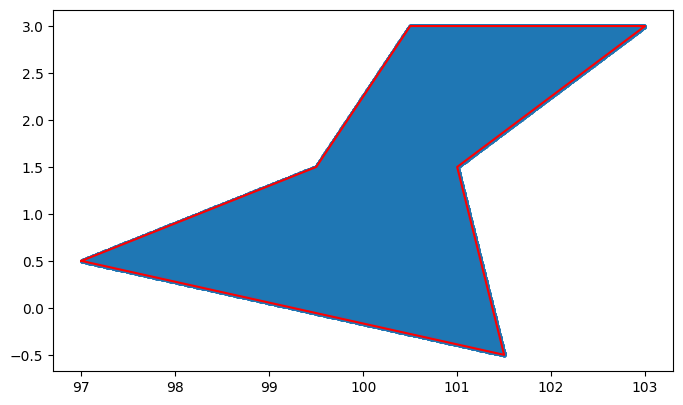

In [6]:
geojson_string = '''{
                "type": "Polygon",
                "coordinates": [
                  [
                    [97, 0.5],
                    [99.5, 1.5],
                    [100.5, 3],
                    [103, 3],
                    [101, 1.5],
                    [101.5, -0.5],
                    [97, 0.5]
                  ]
                ]
                }'''
polyx = shape(json.loads(geojson_string))
poly = pygeos.from_shapely(polyx)
plot_polygon_and_points(poly, gfout.filter(pl.col("lineid") == 3), False, True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Got geometry:  GEOMETRYCOLLECTION (MULTILINESTRING ((104 24, 104.25 24.25, 104.5 24.5), (107 27, 107.18 27.25, 107.6 27)), POLYGON ((100 20.5, 100 21.5, 100.5 22.3, 102 22.3, 101 21.5, 101.25 19.75, 100.5 20.5, 100 20.5)))  with type id:  7  with mode:  zonly,dataframe  with sample:  5
Got geometry:  MULTILINESTRING ((104 24, 104.25 24.25, 104.5 24.5), (107 27, 107.18 27.25, 107.6 27))  with type id:  5  with mode:  zonly,dataframe  with sample:  5
Got geometry:  POLYGON ((100 20.5, 100 21.5, 100.5 22.3, 102 22.3, 101 21.5, 101.25 19.75, 100.5 20.5, 100 20.5))  with type id:  3  with mode:  zonly,dataframe  with sample:  5
MULTILINESTRING ((104 24, 104.25 24.25, 104.5 24.5), (107 27, 107.18 27.25, 107.6 27))


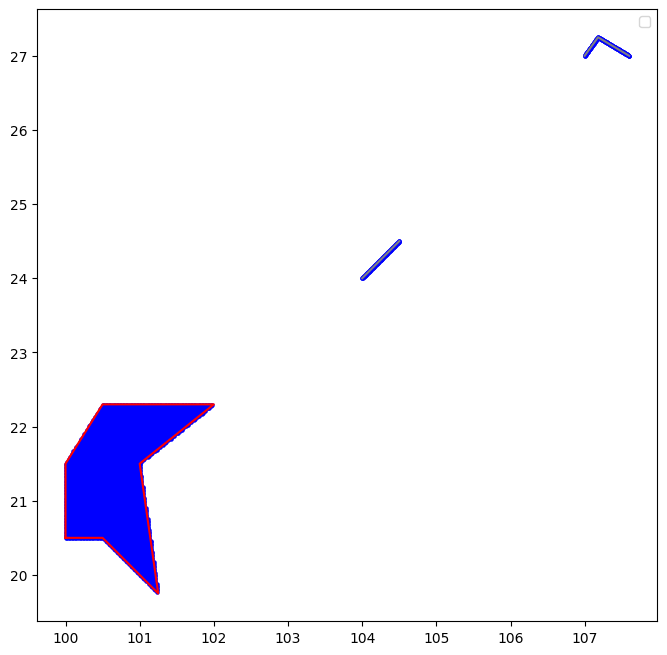

In [6]:
ply_dict = {"type":"Polygon","coordinates":[[[100,20.5],[100,21.5],[100.5,22.3],[102,22.3],[101,21.5],[101.25,19.75],[100.5,20.5]]]}
line_dict = {"type": "MultiLineString", "coordinates": [[[104, 24], [104.25, 24.25], [104.5, 24.5]], [[107, 27], [107.18, 27.25], [107.6, 27]]]}
all_dicts = {"type":"GeometryCollection","geometries":[{"type":"MultiLineString","coordinates":[[[104,24],[104.25,24.25],[104.5,24.5]],[[107,27],[107.18,27.25],[107.6,27]]]},{"type":"Polygon","coordinates":[[[100,20.5],[100,21.5],[100.5,22.3],[102,22.3],[101,21.5],[101.25,19.75],[100.5,20.5]]]}]}
df1, _ = polyhandler(all_dicts, line_id=0, mode="zonly")
polyx = shape(ply_dict)
linex = shape(line_dict)
print(linex)
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")
ax.plot(*polyx.exterior.xy, color="red")
for line in linex.geoms:
    x, y = line.xy
    ax.plot(x, y, color="grey")

ax.scatter(df1["longitude"], df1["latitude"], color="blue", s=5)
ax.legend()
plt.show()

In [38]:
#from shapely.geometry import Polygon, LineString
#from shapely.ops import split
#from shapely.geometry import shape
##from pygeos import polygons

def transform_coords_to_360(polygon):
    """Transform polygon coordinates from -180 - 180 to 0 - 360 range."""
    def transform_coord(lon, lat):
        return [(lon+360 if lon<0 else lon), lat]

    # here polygon not from a shape(geom) but already a geometry, so that cannot use polygon.exterior.coords
        
    transformed_coords = [transform_coord(lon, lat) for lon, lat in pygeos.get_coordinates(polygon)]
    print("transformed coords: ", transformed_coords)
    return Polygon(transformed_coords)

def is_right_polygon(polygon):
    """Check if the polygon is the right part (east of the 180-degree meridian)."""
    return all(0 <= lon <= 180 for lon, _ in polygon.exterior.coords)


def transform_back_to_180(coords, is_right_polygon):
    """Transform coordinates back to -180 to 180 range."""
    def transform(lon):
        if is_right_polygon:
            return 180 - 0.01 / config.arc if lon == 180 else lon
        else:
            return -180 + 0.01 / config.arc if lon == 180 else (lon - 360 if lon > 180 else lon)

    return [[transform(lon), lat] for lon, lat in coords]

def split_polygon_at_180(polygon):
    """Split a polygon at the 180-degree longitude line in 0-360 coordinate system."""
    print("Transform polygon: ", polygon)
    transformed_polygon = transform_coords_to_360(polygon)
    print("Transform: ", transformed_polygon)
    splitter = LineString([(180, 90), (180, -90)])
    result = split(transformed_polygon, splitter)
    print("Split: ", result)
    return result

In [11]:
#test whichSide
testply1 = {"type": "Polygon", "coordinates": [[[-3, 0.5], [-0.5, 1.5], [0.5, 3], [3, 3], [1, 1.5], [1.5, -0.5], [-3, 0.5]]]}
polyx = shape(testply1)
pygeos_poly = pygeos.from_shapely(polyx)

# Check if the polygon crosses the 180-degree line
minx, miny, maxx, maxy = pygeos.bounds(pygeos_poly)
print(whichSide([minx], [maxx]))

cross-zero


In [12]:
testPly = {"type": "Polygon", "coordinates": [[[-179.5, 0.5], [-179.5, 1.5], [179.5, 1.8], [178.2, 1.8], [179, 1.5], [178.5, -0.5], [-179.5, 0.5]]]}
polyx = shape(testPly)
pygeos_poly = pygeos.from_shapely(polyx)

# Check if the polygon crosses the 180-degree line
minx, miny, maxx, maxy = pygeos.bounds(pygeos_poly)
#crosses_180 = minx < -170 and maxx > 170
crosses_180 = whichSide([minx], [maxx]) == 'away-zero'
print(crosses_180)


True


transformed coords:  [[180.5, 0.5], [180.5, 1.5], [179.5, 1.8], [178.2, 1.8], [179.0, 1.5], [178.5, -0.5], [180.5, 0.5]]
Transform:  POLYGON ((180.5 0.5, 180.5 1.5, 179.5 1.8, 178.2 1.8, 179 1.5, 178.5 -0.5, 180.5 0.5))
Split:  GEOMETRYCOLLECTION (POLYGON ((180 1.65, 180.5 1.5, 180.5 0.5, 180 0.25, 180 1.65)), POLYGON ((180 0.25, 178.5 -0.5, 179 1.5, 178.2 1.8, 179.5 1.8, 180 1.65, 180 0.25)))
Part of split result:  POLYGON ((180 1.65, 180.5 1.5, 180.5 0.5, 180 0.25, 180 1.65))
Part of split result:  POLYGON ((180 0.25, 178.5 -0.5, 179 1.5, 178.2 1.8, 179.5 1.8, 180 1.65, 180 0.25))


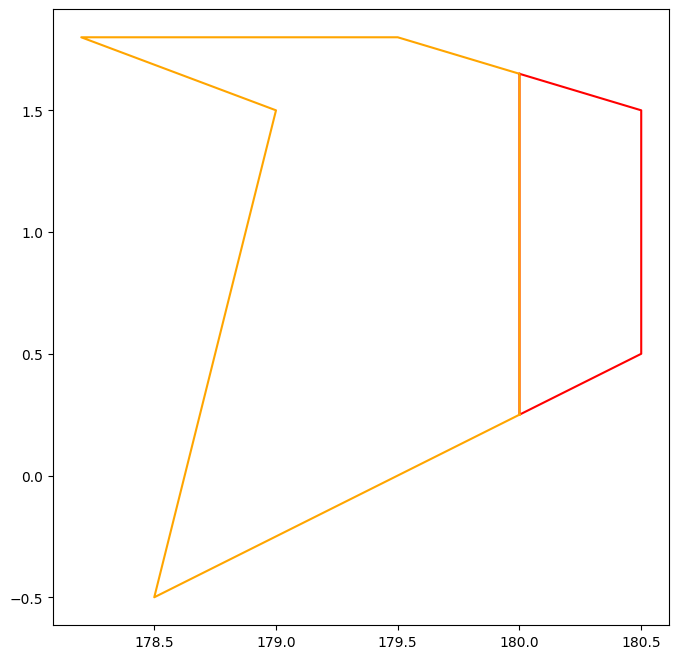

In [18]:
polygon = polyx

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

if crosses_180:
    # Split the polygon at the 180-degree line
    split_poly = split_polygon_at_180(polygon)
    i=0
    for part in split_poly.geoms:
        print("Part of split result: ", part)
        if part.is_empty:
            continue
        colorx = 'red' if i==0 else 'orange'
        ax.plot(*part.exterior.xy, color=colorx)
        i = i+1

#ax.legend()
plt.show()

Part of split result:  POLYGON ((180 1.65, 180.5 1.5, 180.5 0.5, 180 0.25, 180 1.65))
Part of split result:  POLYGON ((180 0.25, 178.5 -0.5, 179 1.5, 178.2 1.8, 179.5 1.8, 180 1.65, 180 0.25))


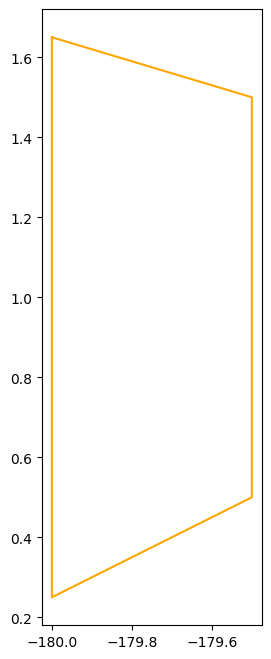

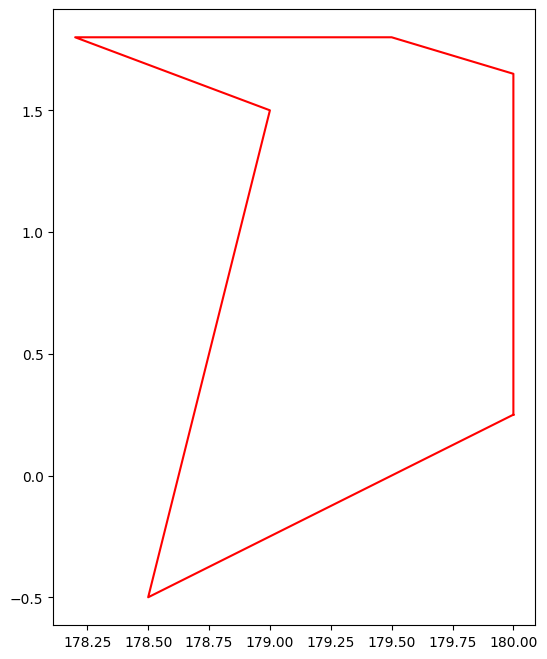

In [20]:
#test transform back to -180 - 180
i = 0

for part in split_poly.geoms:
    print("Part of split result: ", part)
    if part.is_empty:
        continue
    isRight = is_right_polygon(part)
    transformed_coords = transform_back_to_180(part.exterior.coords, isRight)
    transformed_polygon = Polygon(transformed_coords)   
    colorx = 'red' if isRight else 'orange'
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_aspect("equal")
    ax.plot(*transformed_polygon.exterior.xy, color=colorx)
    i = i+1

In [6]:
print(config.ds)
print(config.arc)

<xarray.Dataset>
Dimensions:    (lat: 43200, lon: 86400)
Coordinates:
  * lat        (lat) float64 -90.0 -89.99 -89.99 -89.99 ... 89.99 89.99 90.0
  * lon        (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    elevation  (lat, lon) int16 dask.array<chunksize=(675, 2700), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    comment:      The data in the GEBCO_2020 Grid should not be used for navi...
    history:      Information on the development of the data set and the sour...
    institution:  On behalf of the General Bathymetric Chart of the Oceans (G...
    node_offset:  1.0
    references:   DOI: 10.5285/836f016a-33be-6ddc-e053-6c86abc0788e
    source:       The GEBCO_2020 Grid is the latest global bathymetric produc...
    title:        The GEBCO_2020 Grid - a continuous terrain model for oceans...
240


In [46]:
def zdata_bbox(bbox, crosses_180=False, isRight=False):
    ds = config.ds  #config.ds is the global variable of zarr dataset 
    arc = config.arc
    minx, miny, maxx, maxy = bbox
    # if crosses_180, left polygon's longitude is like maxx = -179.5, minx = -179.999
    # if crosses_180, right polygon's longitude is like maxx= 179.99, minx = 179.5
    lftx = minx - 0.25/arc if not crosses_180 or (crosses_180 and isRight) else max(minx - 0.25/arc, -180 + 0.01/arc)
    rgtx = min(maxx + 1.5/arc, 180 - 0.01/arc) if not crosses_180 or (crosses_180 and isRight) else maxx + 1.5/arc
    print("Debug left, right to slice: ", lftx, rgtx, " and bbox: ", bbox, " and condition: ", crosses_180, isRight)
    subset_data = ds.sel(
        lon=slice(lftx, rgtx),
        lat=slice(miny - 0.25 / arc, maxy + 1.5 / arc),
    )
    return subset_data

def process_polygon_part(polygon, line_id, mode, crosses_180=False):
    isRight = is_right_polygon(polygon) if crosses_180 else False
    if crosses_180:
        trans_coords = transform_back_to_180(polygon.exterior.coords, isRight)
    else:
        trans_coords = transform_back_to_180(pygeos.get_coordinates(polygon), isRight)
    trans_poly = pygeos.from_shapely(Polygon(trans_coords))
    print("Debug trans_back_to_180: ", trans_coords, trans_poly)
    minx, miny, maxx, maxy = pygeos.bounds(trans_poly)
    subset_data = zdata_bbox((minx, miny, maxx, maxy), crosses_180, isRight)

    # Create a mask for data points within the polygon
    lons, lats = np.meshgrid(subset_data.lon, subset_data.lat)
    points = pygeos.points(lons.ravel(), lats.ravel())
    mask = pygeos.contains(trans_poly, points)  # .within(points, polygon)
    # Reshape the mask to match the dimensions of the elevation data
    mask_reshaped = mask.reshape(lats.shape)

    # Apply mask and create DataFrame
    elevation_data = subset_data.elevation.values[mask_reshaped]
    masked_lons, masked_lats = lons[mask_reshaped], lats[mask_reshaped]
    # if crosses_180, longitude is like -179.5....-179.999(descending), 179.999,..,179.5(desending) 
    df = pl.DataFrame(
            {
                "longitude": masked_lons.ravel(),
                "latitude": masked_lats.ravel(),
                "z": elevation_data.ravel(),
            }
        ).sort("longitude", "latitude", descending=[crosses_180, True])
    
    if "zonly" in mode:
        append_cols = [
            pl.lit(line_id).cast(pl.Int16).alias("lineid"),
        ]
    else:
        append_cols = [
            pl.lit(None).cast(pl.Float64).alias("distance"),
            pl.lit(line_id).cast(pl.Int16).alias("lineid"),
        ]
    
    df = df.with_columns(append_cols)
    return df


In [48]:
def process_polygon2(polygon, line_id, mode):
    #pygeos_poly = pygeos.from_shapely(polygon)
    minx, miny, maxx, maxy = pygeos.bounds(polygon)
    #crosses_180 = minx < -170 and maxx > 170
    crosses_180 = whichSide([minx], [maxx]) == 'away-zero'

    if crosses_180:
        split_poly = split_polygon_at_180(polygon)
        dataframes = []

        for part in split_poly.geoms:
            if part.is_empty:
                continue
            df = process_polygon_part(part, line_id, mode, crosses_180)
            dataframes.append(df)

        df = pl.concat(dataframes)
    else:
        df = process_polygon_part(polygon, line_id, mode, False)

    return df

In [23]:
from src.polyhandler import coords_zprof, process_linestring
def polyhandler2(geojson_input, line_id=0, mode=""):
    dataframes = []
    hasFeature = False
    mode = (
        "dataframe"
        if mode is None
        else (mode if "dataframe" in mode else mode + ",dataframe")
    )
    if "zonly" in mode.lower():
        consistent_schema = {
            "longitude": pl.Float64,
            "latitude": pl.Float64,
            "z": pl.Float64,
            "lineid": pl.Int16,
        }
    else:
        consistent_schema = {
            "longitude": pl.Float64,
            "latitude": pl.Float64,
            "z": pl.Float64,
            "distance": pl.Float64,
            "lineid": pl.Int16,
        }

    if isinstance(geojson_input, pygeos.lib.Geometry):
        geometry = geojson_input
    elif "type" in geojson_input or isinstance(geojson_input, str):
        if isinstance(geojson_input, str):
            geojson = json.loads(geojson_input)
        else:
            geojson = geojson_input

        if geojson["type"] == "FeatureCollection":
            hasFeature = True
            pts_coords = []
            # print("Got Feature collection and 0: ", geojson["features"][0]["geometry"])
            for feature in geojson["features"]:
                geom = feature["geometry"]
                if (
                    geom["type"] == "Point"
                    and mode is not None
                    and "connect_pt" in mode.lower()
                ):
                    pts_coords.append(geom["coordinates"])
                elif (
                    geom["type"] == "MultiPoint"
                    and mode is not None
                    and "connect_pts" in mode.lower()
                ):
                    pts_coords.extend(geom["coordinates"])
                else:
                    # print("Feature in collection: ", geom["type"], " and now pts_coords: ", pts_coords)
                    if len(pts_coords) > 0:
                        df = coords_zprof(np.array(pts_coords), line_id, mode)
                        dataframes.append(df)
                        line_id += 1
                        pts_coords = []

                    geometry = pygeos.from_shapely(shape(geom))
                    df, line_id = polyhandler2(geometry, line_id, mode)
                    dataframes.append(df)

            if len(pts_coords) > 0:
                df = coords_zprof(np.array(pts_coords), line_id, mode)
                dataframes.append(df)
                line_id += 1
        else:
            geometry = pygeos.from_shapely(shape(geojson))
    else:
        raise ValueError("Input must be a GeoJSON object or a PyGEOS Geometry")

    if not hasFeature:
        geom_type = pygeos.get_type_id(geometry)
        print(
            "Got geometry: ",
            geometry,
            " with type id: ",
            geom_type,
            " with mode: ",
            mode,
        )
        # interval = 15 / 3600  # 15 arc-seconds in degrees

        if geom_type in [0, 1, 2, 4]:  # POINT, LINESTRING, LINEARRING, MULTIPOINT
            df = process_linestring(geometry, line_id, mode)
            dataframes.append(df)
            line_id += 1
        elif geom_type == 3:  # POLYGON
            df = process_polygon2(geometry, line_id, mode)
            dataframes.append(df)
            line_id += 1
        elif geom_type in [5]:  # MULTILINESTRING
            for part in pygeos.get_parts(geometry):
                df = process_linestring(part, line_id, mode)
                dataframes.append(df)
                line_id += 1
        elif geom_type == 6:  # MULTIPOLYGON
            for polygon in pygeos.get_parts(geometry):
                df = process_polygon2(polygon, line_id, mode)
                dataframes.append(df)
                line_id += 1
        elif geom_type == 7:  # GEOMETRYCOLLECTION
            for part in pygeos.get_parts(geometry):
                part_df, line_id = polyhandler2(part, line_id, mode)
                dataframes.append(part_df)

    if dataframes:
        return pl.concat([df.cast(consistent_schema) for df in dataframes]), line_id
    else:
        return pl.DataFrame([], schema=consistent_schema), line_id


In [5]:
# testPly = {"type": "Polygon", "coordinates": [[[-179.5, 0.5], [-179.5, 1.5], [179.5, 1.8], [178.2, 1.8], [179, 1.5], [178.5, -0.5], [-179.5, 0.5]]]}
testPly = {"type": "Polygon", "coordinates": [[[121, 22.5], [121, 23.5], [122, 23.5], [122, 22.5], [121, 22.5]]]}
mode = "zonly,lon360"
df, _ = polyhandler(testPly, line_id=0, mode=mode, sample=1, poly_sample=8)
print(df)

Got geometry:  POLYGON ((121 22.5, 121 23.5, 122 23.5, 122 22.5, 121 22.5))  with type id:  3  with mode:  zonly,lon360,dataframe  with sample:  8
shape: (900, 4)
┌────────────┬───────────┬─────────┬────────┐
│ longitude  ┆ latitude  ┆ z       ┆ lineid │
│ ---        ┆ ---       ┆ ---     ┆ ---    │
│ f64        ┆ f64       ┆ f64     ┆ i16    │
╞════════════╪═══════════╪═════════╪════════╡
│ 121.002083 ┆ 23.46875  ┆ 2667.0  ┆ 0      │
│ 121.002083 ┆ 23.435417 ┆ 2712.0  ┆ 0      │
│ 121.002083 ┆ 23.402083 ┆ 2903.0  ┆ 0      │
│ 121.002083 ┆ 23.36875  ┆ 2696.0  ┆ 0      │
│ 121.002083 ┆ 23.335417 ┆ 2729.0  ┆ 0      │
│ …          ┆ …         ┆ …       ┆ …      │
│ 121.96875  ┆ 22.635417 ┆ -4662.0 ┆ 0      │
│ 121.96875  ┆ 22.602083 ┆ -4654.0 ┆ 0      │
│ 121.96875  ┆ 22.56875  ┆ -4625.0 ┆ 0      │
│ 121.96875  ┆ 22.535417 ┆ -4593.0 ┆ 0      │
│ 121.96875  ┆ 22.502083 ┆ -4857.0 ┆ 0      │
└────────────┴───────────┴─────────┴────────┘


Part of split result:  POLYGON ((121 22.5, 121 23.5, 122 23.5, 122 22.5, 121 22.5))


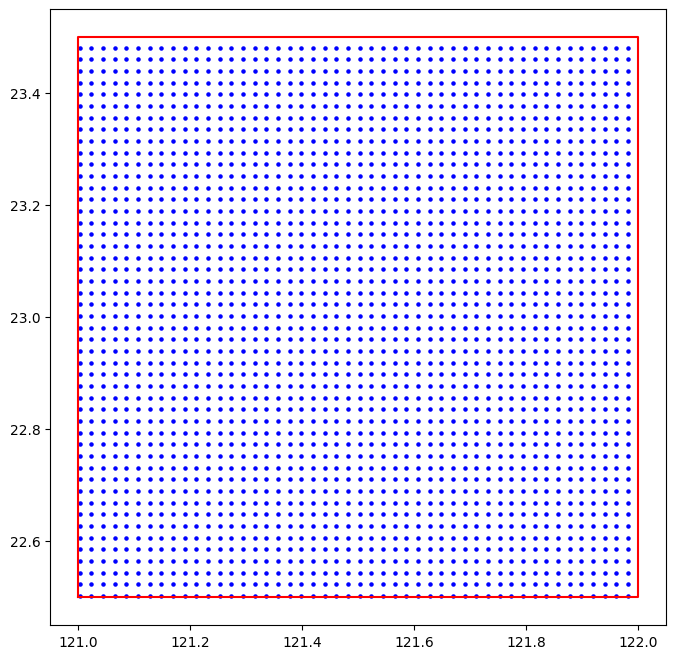

In [9]:
from src.polyhandler import split_polygon_at_180
if "lon360" not in mode:
    (pl.when(df["longitude"] < 0)
        .then(df["longitude"] + 360)
        .otherwise(df["longitude"])
        .alias("lon")
    )

polyx = shape(testPly)
polygon = pygeos.from_shapely(polyx)

fig, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

if True: #crosses_180:
    # Split the polygon at the 180-degree line
    split_poly = split_polygon_at_180(polygon)
    i=0
    for part in split_poly.geoms:
        print("Part of split result: ", part)
        if part.is_empty:
            continue
        colorx = 'red' if i==0 else 'orange'
        ax.plot(*part.exterior.xy, color=colorx)
        i = i+1

if "lon360" not in mode:
    ax.scatter(df["lon"], df["latitude"], color="blue", s=5)
else:
    ax.scatter(df["longitude"], df["latitude"], color="blue", s=5)    
#ax.legend()
plt.show()

In [12]:
#generate mock data
df_filtered = df.slice(336, 528).select(["longitude", "latitude", "z"])
df_filtered.write_csv("../simu/test_mock_in_threejs.csv")

In [2]:
def geojson_validator(json_obj):
    return ("type" in json_obj) and (
        (json_obj["type"] == "FeatureCollection" and "features" in json_obj)
        or (
            json_obj["type"] == "Feature" and "geometry" in json_obj and json_obj["geometry"]["type"]
            in [
                "Point",
                "LineString",
                "Polygon",
                "MultiPoint",
                "MultiLineString",
                "MultiPolygon",
                "GeometryCollection",
            ]
        )
        or (
            json_obj["type"]
            in [
                "Point",
                "LineString",
                "Polygon",
                "MultiPoint",
                "MultiLineString",
                "MultiPolygon",
                "GeometryCollection",
            ]
        )
    )

In [3]:
gjsonx = {
  "type": "Feature",
  "properties": {},
  "geometry": {
    "type": "GeometryCollection",
    "geometries": [
      {
        "type": "Point",
        "coordinates": [100.0, 0.0]
      },
      {
        "type": "LineString",
        "coordinates": [
          [101.0, 0.0],
          [102.0, 1.0]
        ]
      },
      {
        "type": "Polygon",
        "coordinates": [
          [
            [100.0, 0.0],
            [101.0, 0.0],
            [101.0, 1.0],
            [100.0, 1.0],
            [100.0, 0.0]
          ]
        ]
      }
    ]
  }
}
print(geojson_validator(gjsonx))
print(isinstance(gjsonx, pygeos.lib.Geometry))

True
False


In [9]:
print(geojson_validator(testPly))
print(geojson_validator(all_dicts))
print(geojson_validator(line_dict))

True
True
True


In [4]:
df, _ = polyhandler(gjsonx, line_id=0, mode="zonly", sample=1, poly_sample=5)
print(df)


Got geometry:  GEOMETRYCOLLECTION (POINT (100 0), LINESTRING (101 0, 102 1), POLYGON ((100 0, 101 0, 101 1, 100 1, 100 0)))  with type id:  7  with mode:  zonly,dataframe  with sample:  5
Got geometry:  POINT (100 0)  with type id:  0  with mode:  zonly,dataframe  with sample:  5
Got geometry:  LINESTRING (101 0, 102 1)  with type id:  1  with mode:  zonly,dataframe  with sample:  5
Got geometry:  POLYGON ((100 0, 101 0, 101 1, 100 1, 100 0))  with type id:  3  with mode:  zonly,dataframe  with sample:  5
shape: (2_547, 4)
┌────────────┬──────────┬───────┬────────┐
│ longitude  ┆ latitude ┆ z     ┆ lineid │
│ ---        ┆ ---      ┆ ---   ┆ ---    │
│ f64        ┆ f64      ┆ f64   ┆ i16    │
╞════════════╪══════════╪═══════╪════════╡
│ 100.0      ┆ 0.0      ┆ 343.0 ┆ 0      │
│ 101.0      ┆ 0.0      ┆ 67.0  ┆ 1      │
│ 101.003125 ┆ 0.003125 ┆ 81.0  ┆ 1      │
│ 101.007292 ┆ 0.007292 ┆ 67.0  ┆ 1      │
│ 101.011458 ┆ 0.011458 ┆ 53.0  ┆ 1      │
│ …          ┆ …        ┆ …     ┆ …      

In [7]:
df1, _ = polyhandler(all_dicts, line_id=0, mode="zonly", sample=1, poly_sample=5)
print(df1)

Got geometry:  GEOMETRYCOLLECTION (MULTILINESTRING ((104 24, 104.25 24.25, 104.5 24.5), (107 27, 107.18 27.25, 107.6 27)), POLYGON ((100 20.5, 100 21.5, 100.5 22.3, 102 22.3, 101 21.5, 101.25 19.75, 100.5 20.5, 100 20.5)))  with type id:  7  with mode:  zonly,dataframe  with sample:  5
Got geometry:  MULTILINESTRING ((104 24, 104.25 24.25, 104.5 24.5), (107 27, 107.18 27.25, 107.6 27))  with type id:  5  with mode:  zonly,dataframe  with sample:  5
Got geometry:  POLYGON ((100 20.5, 100 21.5, 100.5 22.3, 102 22.3, 101 21.5, 101.25 19.75, 100.5 20.5, 100 20.5))  with type id:  3  with mode:  zonly,dataframe  with sample:  5
shape: (5_677, 4)
┌────────────┬───────────┬────────┬────────┐
│ longitude  ┆ latitude  ┆ z      ┆ lineid │
│ ---        ┆ ---       ┆ ---    ┆ ---    │
│ f64        ┆ f64       ┆ f64    ┆ i16    │
╞════════════╪═══════════╪════════╪════════╡
│ 104.0      ┆ 24.0      ┆ 1979.0 ┆ 0      │
│ 104.003125 ┆ 24.003125 ┆ 1923.0 ┆ 0      │
│ 104.007292 ┆ 24.007292 ┆ 1871.0 ┆ 